In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-03-06 15:45:29.743998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 15:45:35.160460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-06 15:45:49.825718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-06 15:45:49.827218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mlui02.ific.uv.es
2024-03-06 15:45:49.827931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mlui02.ific.uv.es
2024-03-06 15:45:49.828202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagno

In [4]:
# jax.config.update("jax_debug_nans", False)

In [5]:
import matplotlib.pyplot as plt

In [6]:
id = "6rhldh50"

In [7]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")

In [8]:
config = ConfigDict(prev_run.config["_fields"])

In [9]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [10]:
#| exporti
class FreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between frequencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):
        gamma_f = self.param("gamma_f",
                             k_array(1/0.4, arr=fmean),
                             (inputs.shape[-1],))
        gamma_theta = self.param("gamma_theta",
                                 equal_to(jnp.ones(shape=(len(theta_mean),)) * 20),
                                 (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, 1)
        kernel = kernel[None,None,:,:]
        # kernel = jnp.tile(kernel, reps=n_groups)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, A=1):
        return A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [11]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = FreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs, c0 = GDNGamma(return_coef=True)(inputs)
        else: outputs, c0 = GDN(kernel_size=(1,1), apply_independently=True, return_coef=True)(inputs)        
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs, c1 = GDN(kernel_size=(1,1), apply_independently=True, return_coef=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs, c2 = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, return_coef=True)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs, c0, c1, c2

In [13]:
class Model(nn.Module):
    def setup(self):
        self.perceptnet = PerceptNet()
        self.coefs = self.param("coefs",
                           nn.initializers.ones_init(),
                           (4,))
    @nn.compact
    def __call__(self,
                 img,
                 img_dist,
                 **kwargs,
                 ):
        

        outputs, c0, c1, c2 = self.perceptnet(img, **kwargs)
        outputs_dist, c0_dist, c1_dist, c2_dist = self.perceptnet(img_dist, **kwargs)

        d = self.distance(outputs, outputs_dist)
        d_0 = self.distance(c0, c0_dist)
        d_1 = self.distance(c1, c1_dist)
        d_2 = self.distance(c2, c2_dist)

        dist = d*self.coefs[0] + d_0*self.coefs[1] + d_1*self.coefs[2] + d_2*self.coefs[3]
        return dist

    @staticmethod
    def distance(img, img_dist):
        diff = rearrange(img-img_dist, "b h w c -> b (h w c)")
        return optax.safe_norm(diff, min_norm=0., ord=2, axis=1)
    
    def encode(self, img, **kwargs):
        return self.perceptnet(img, **kwargs)


## Define the metrics with `clu`

In [14]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [15]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [16]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape), jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [17]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [18]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [19]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [20]:
state = create_train_state(Model(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [21]:
import flax

In [22]:
def check_trainable(path):
    if not config.A_GDNSPATIOFREQORIENT:
        if ("GDNSpatioFreqOrient_0" in path) and ("A" in path):
            return True
    if "Color" in path:
        if not config.TRAIN_JH:
            return True
    if "CenterSurroundLogSigmaK_0" in path:
        if not config.TRAIN_CS:
            return True
    return False

In [23]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [24]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [25]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [26]:
state = create_train_state(Model(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [27]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [28]:
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [29]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

1849

## Forward pass of the generated stimuli

In [30]:
from functools import partial

In [31]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [54]:
@jax.jit
def forward_intermediates(state, inputs):
    # return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)
    return state.apply_fn({"params": state.params, **state.state}, inputs, inputs, train=False, capture_intermediates=True)

In [33]:
import cv2

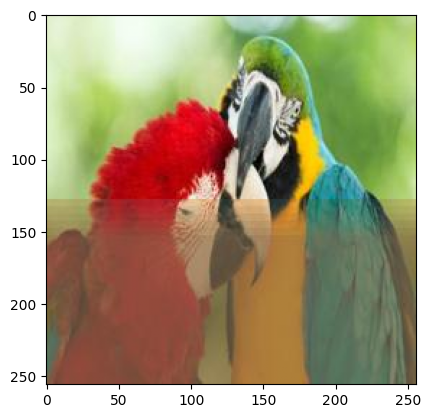

In [34]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [55]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 6.64 s, sys: 137 ms, total: 6.78 s
Wall time: 1.71 s


(1,)

In [59]:
extras["intermediates"]["perceptnet"].keys()

frozen_dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioFreqOrient_0', 'GDN_0', 'GaborLayerGammaRepeat_0', '__call__'])

## Checking the weights

In [56]:
state.params.keys()

frozen_dict_keys(['coefs', 'perceptnet'])

### Gamma Correction

In [62]:
if config.USE_GAMMA: layer_name = "GDNGamma_0"
else: layer_name = "GDN_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    bias: array([0.21149729], dtype=float32),
    kernel: array([0.25672054], dtype=float32),
})

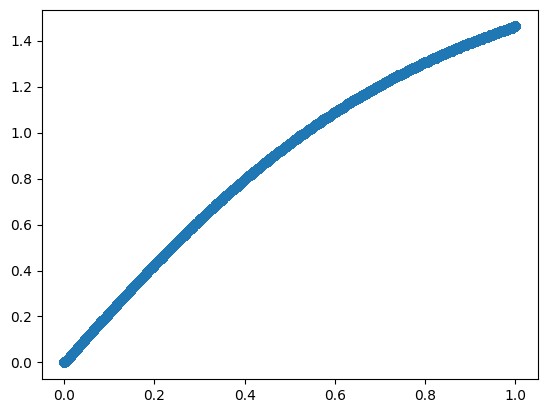

In [64]:
plt.scatter(kk.ravel(),
            extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0].ravel())
plt.show()

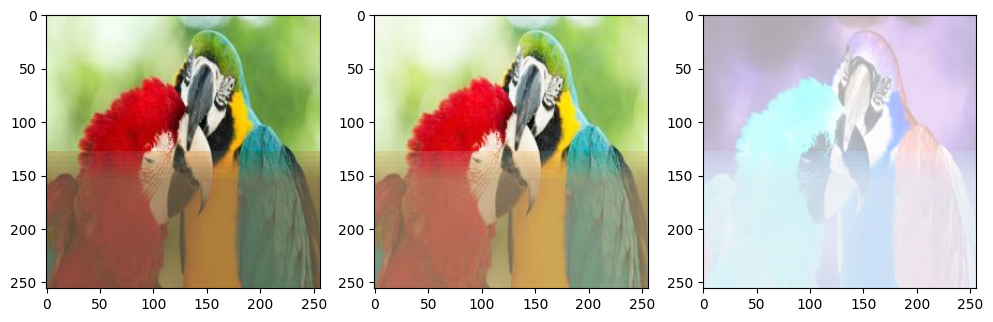

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0][0]/extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0][0].max())
axes[2].imshow(extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][1][0]/extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][1][0].max())
plt.show()

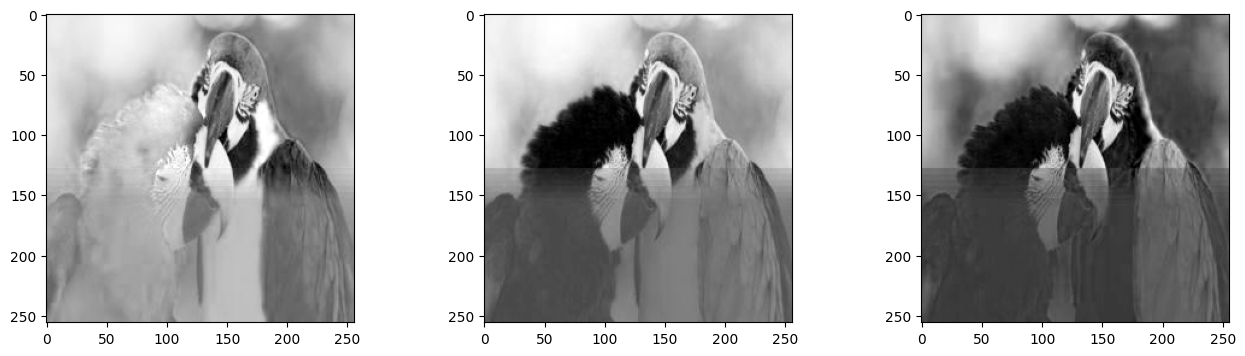

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [83]:
if config.USE_GAMMA: prev_layer = "GDNGamma_0"
else: prev_layer = "GDN_0"
layer_name = "Color"

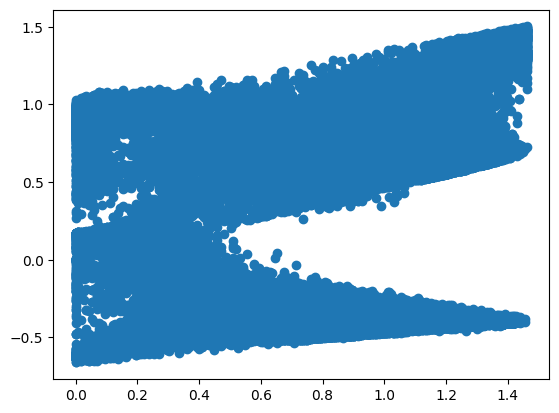

In [85]:
plt.scatter(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0].ravel())
plt.show()

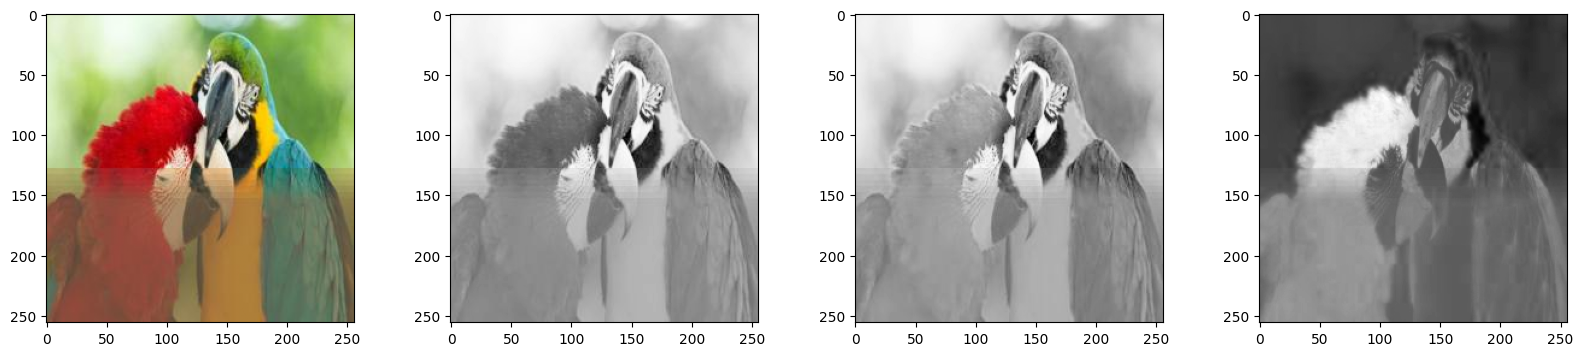

In [87]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
axes[0].imshow(kk[0])
for i, ax in enumerate(axes[1:]):
    ax.imshow(extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [88]:
prev_layer = "Color"
layer_name = "GDN_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.9707443, 0.6367724, 0.8708864], dtype=float32),
        kernel: array([[[[0.5588433 , 0.00132858, 0.01933756]]]], dtype=float32),
    },
})

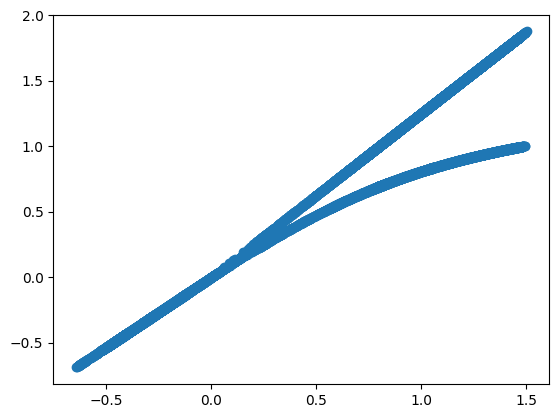

In [89]:
plt.scatter(nn.max_pool(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0].ravel())
plt.show()

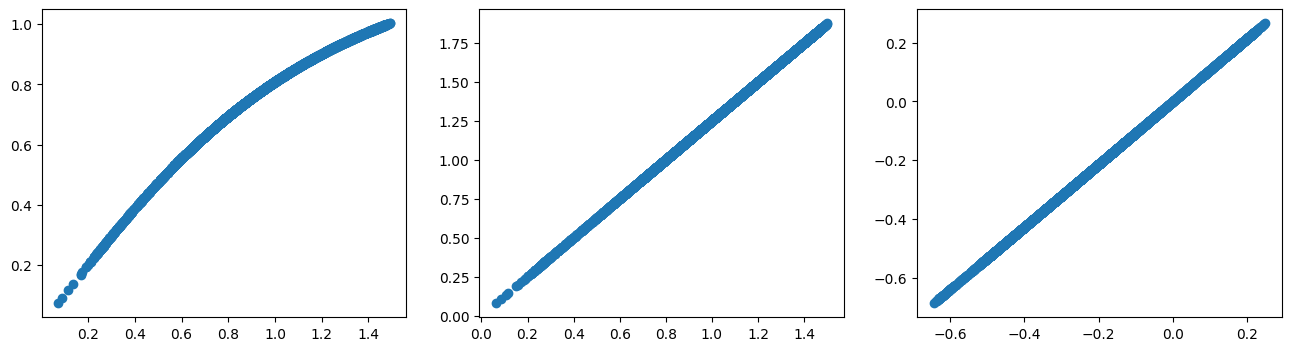

In [90]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [92]:
prev_layer = "GDN_0"
layer_name = "CenterSurroundLogSigmaK_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    A: array([0.93735296, 0.44010413, 0.34499508, 0.26570567, 3.607565  ,
           2.0044565 , 0.        , 1.2906271 , 1.0873278 ], dtype=float32),
    K: array([1.0259922, 1.0376209, 1.4630976, 1.1309751, 4.2723117, 1.1366227,
           1.0958489, 1.4409101, 4.498058 ], dtype=float32),
    logsigma: array([-2.6384647, -1.6921839, -1.4443429, -2.0449805, -1.7718415,
           -2.6262946, -2.160911 , -1.1748565, -2.057    ], dtype=float32),
})

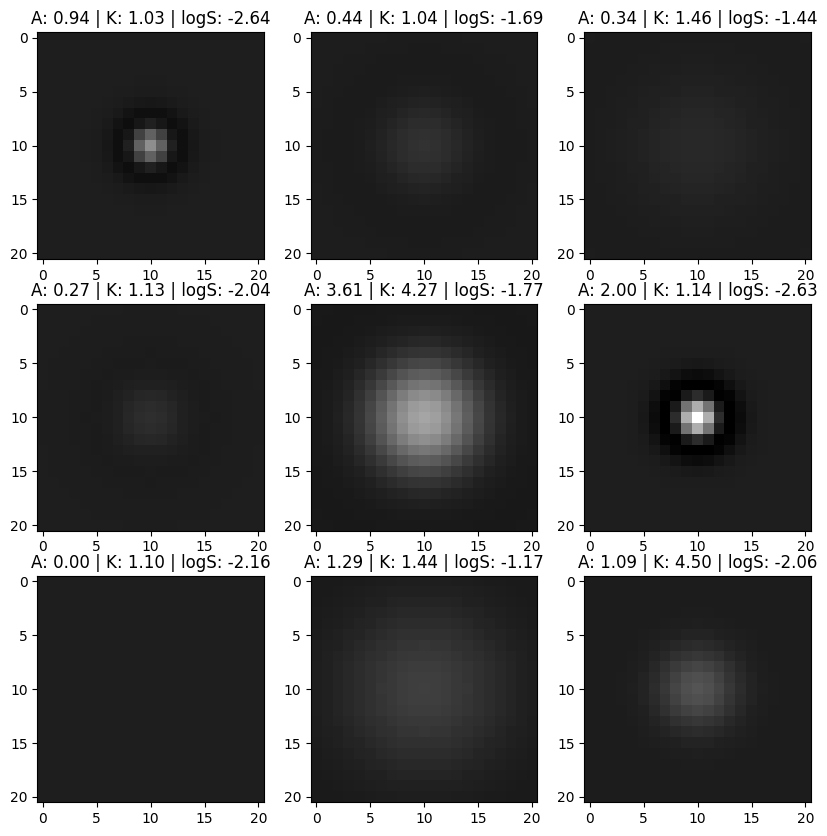

In [100]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"].min(), state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.set_title(f'A: {state.params["perceptnet"][layer_name]["A"][k]:.2f} | K: {state.params["perceptnet"][layer_name]["K"][k]:.2f} | logS: {state.params["perceptnet"][layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

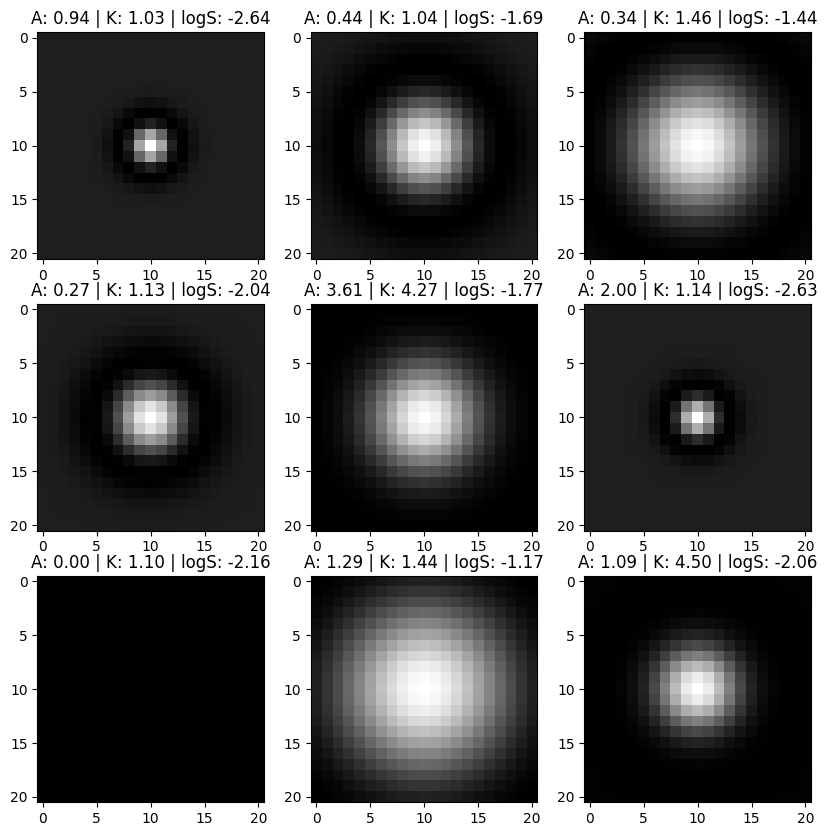

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"].min(), state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"][:,:,i,j], cmap="gray")
        ax.set_title(f'A: {state.params["perceptnet"][layer_name]["A"][k]:.2f} | K: {state.params["perceptnet"][layer_name]["K"][k]:.2f} | logS: {state.params["perceptnet"][layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [104]:
prev_layer = "CenterSurroundLogSigmaK_0"
layer_name = "GDNGaussian_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([0.19435354, 1.3219947 , 1.2133955 ], dtype=float32),
        bias: array([0.04026783, 1.231494  , 1.6852281 ], dtype=float32),
        gamma: array([34.59587 , 22.08548 , 28.367285], dtype=float32),
    },
})

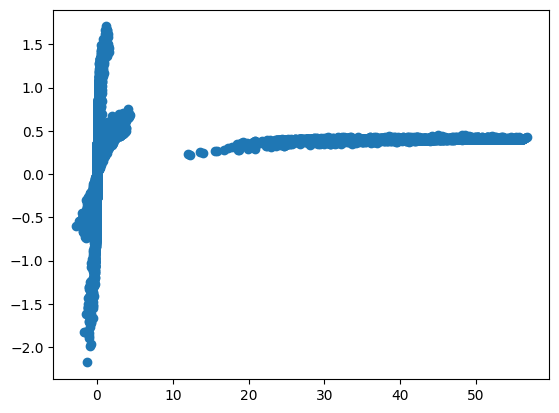

In [106]:
plt.scatter(nn.max_pool(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0].ravel())
plt.show()

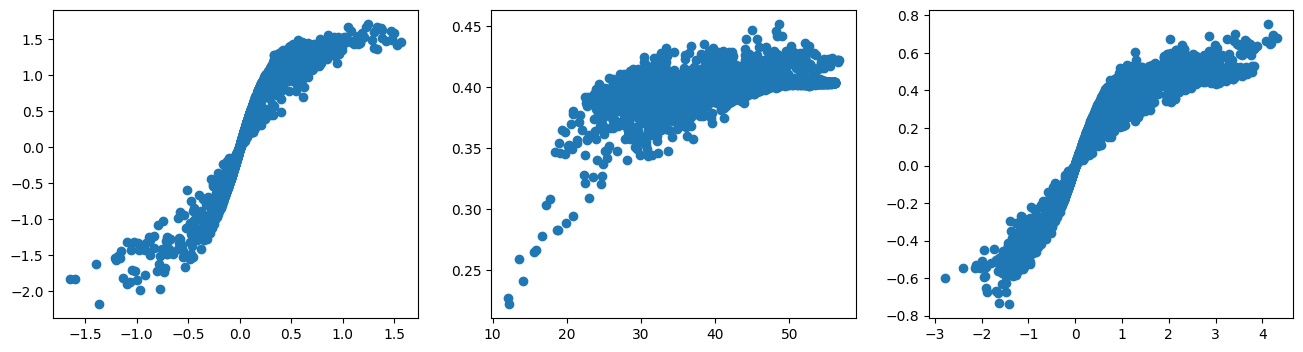

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0][0,:,:,i].ravel())
plt.show()

In [109]:
state.params["perceptnet"]["GDNGaussian_0"]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([0.19435354, 1.3219947 , 1.2133955 ], dtype=float32),
        bias: array([0.04026783, 1.231494  , 1.6852281 ], dtype=float32),
        gamma: array([34.59587 , 22.08548 , 28.367285], dtype=float32),
    },
})

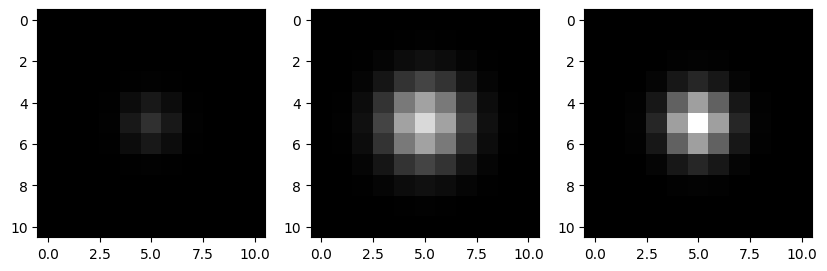

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

In [ ]:
state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,0].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,1].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,2].sum()

(3.7824259, 4.0380826, 0.9951123)

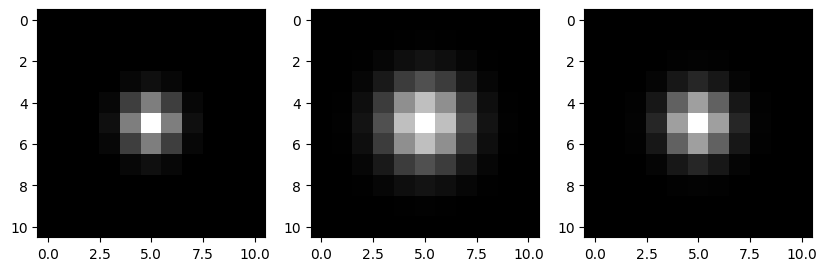

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"]["perceptnet"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [113]:
prev_layer = "GDNGaussian_0"
layer_name = "GaborLayerGammaRepeat_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    A: array([[2.82117367e+00, 3.31927121e-01, 2.54927731e+00, 3.34131169e+00,
            0.00000000e+00, 7.91814148e-01, 3.46523151e-02, 1.20995712e+00,
            2.30523682e+00, 3.11417890e+00, 2.62927246e+00, 2.71535993e-01,
            1.78891277e+00, 6.81635857e-01, 4.91568899e-05, 1.21280646e+00,
            6.68798566e-01, 0.00000000e+00, 1.02929842e+00, 0.00000000e+00,
            1.43035424e+00, 1.83159369e-12, 0.00000000e+00, 3.52023959e+00,
            1.41266644e+00, 0.00000000e+00, 1.52055120e+00, 1.16366501e+01,
            1.56302106e+00, 4.06871229e-01, 1.88988064e-15, 1.48652506e+00,
            0.00000000e+00, 1.80429482e+00, 1.15714049e+00, 0.00000000e+00,
            1.25164455e-02, 2.42033148e+00, 0.00000000e+00, 2.90550590e+00,
            2.31052852e+00, 3.03370380e+00, 8.78416955e-01, 2.87749958e+00,
            0.00000000e+00, 2.85098219e+00, 3.97222668e-01, 6.51808798e-01,
            2.19725275e+00, 1.24076414e+00, 1.63724828e+00, 2.85958439e-

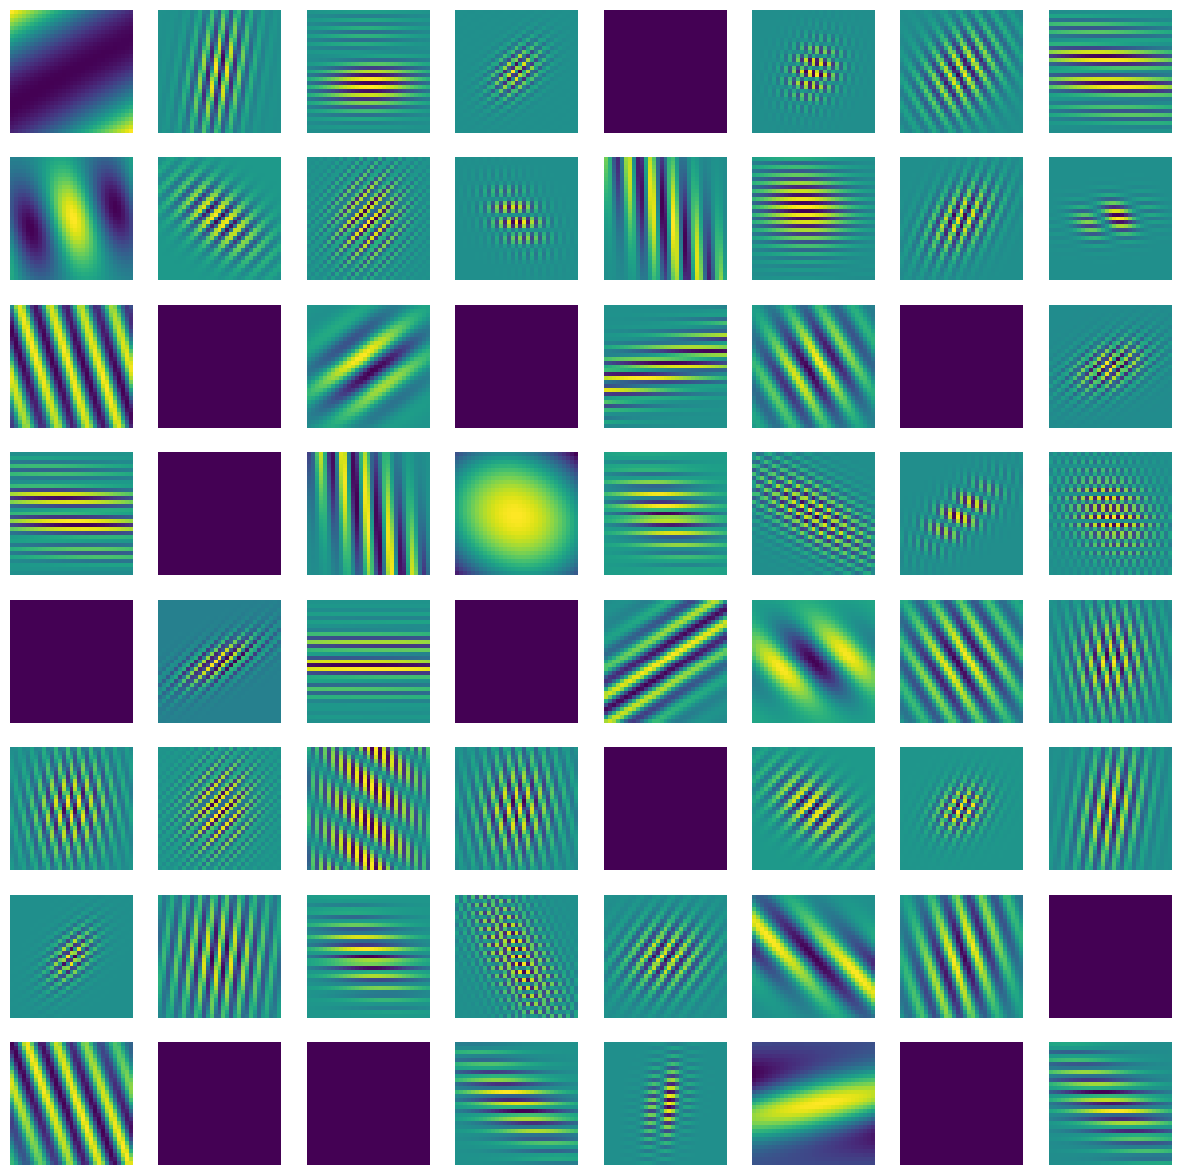

In [114]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [116]:
kernel = state.state["precalc_filter"]["perceptnet"][layer_name]["kernel"]
kernel.shape

(31, 31, 3, 128)

In [117]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

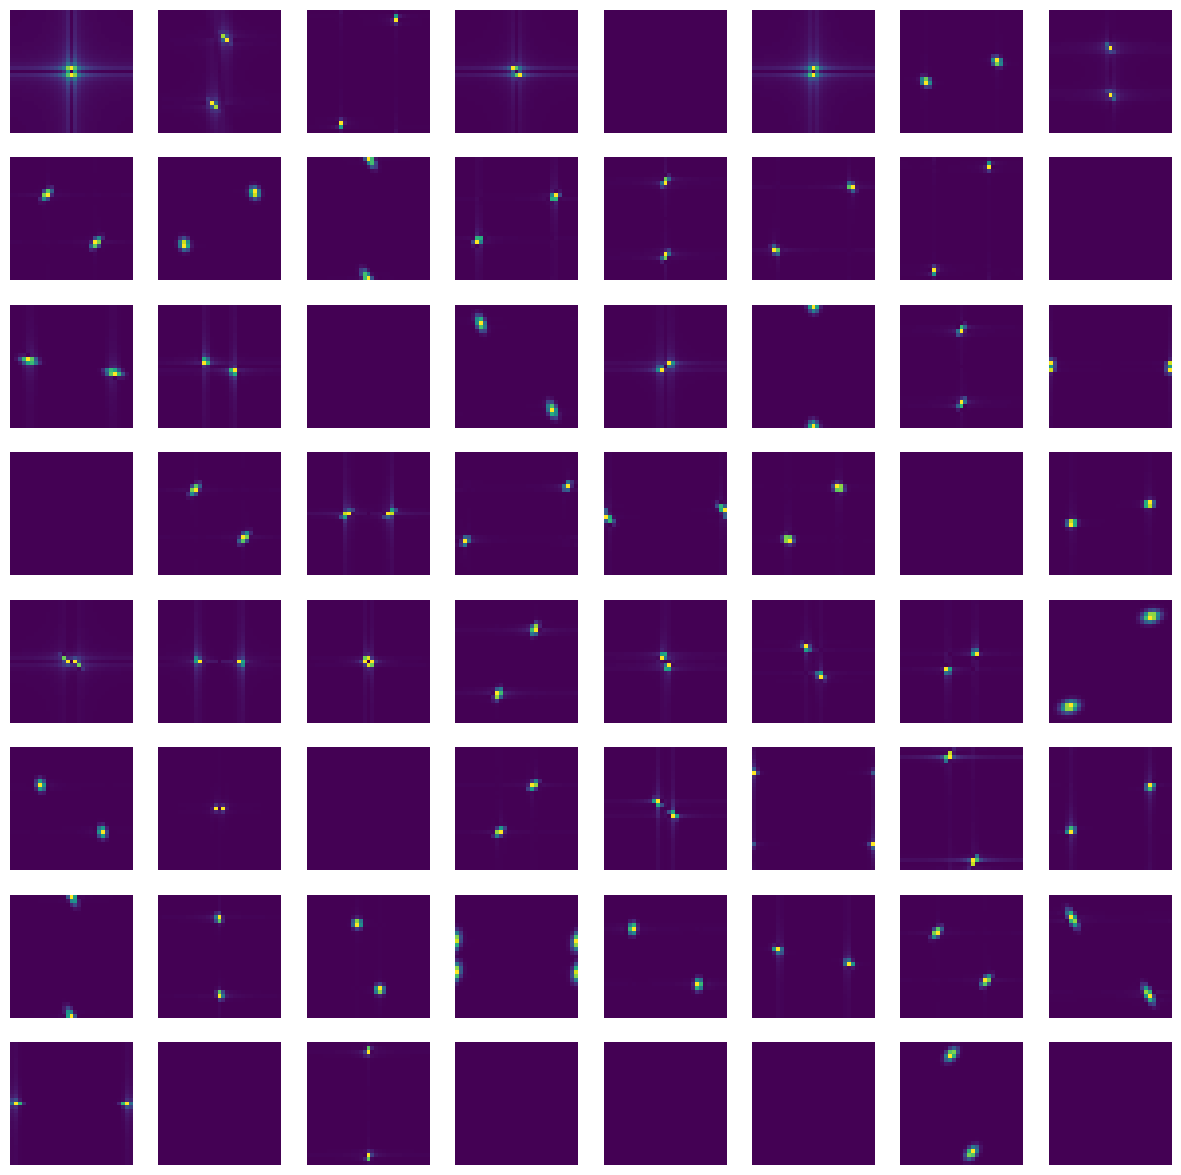

In [118]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

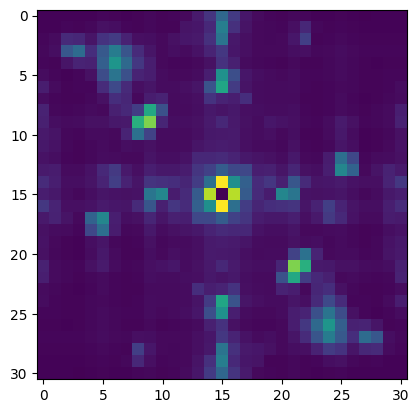

In [119]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

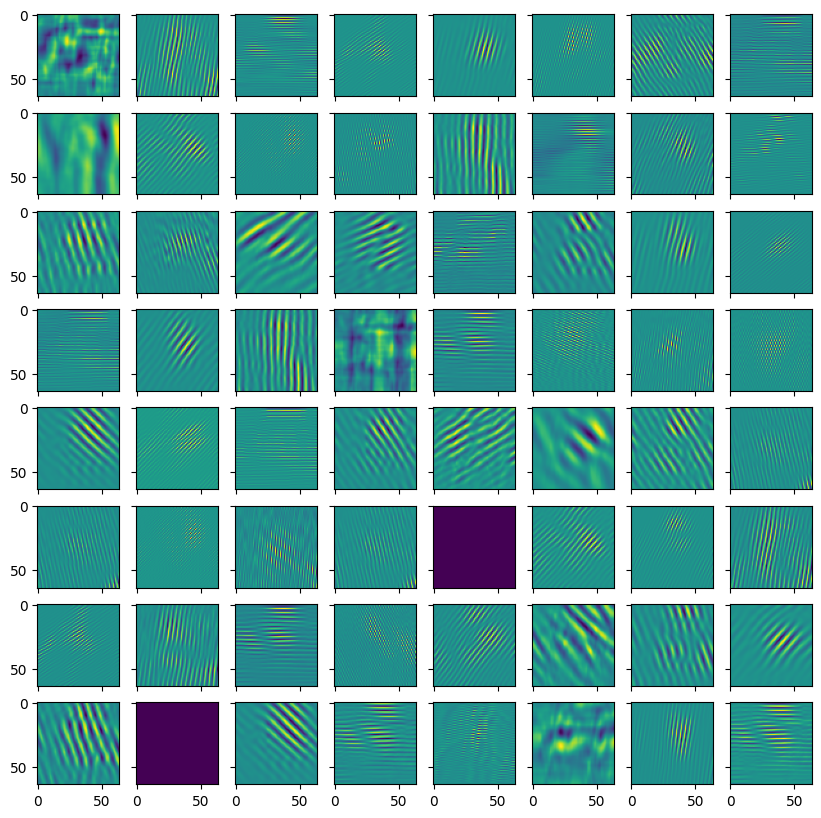

In [120]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0][0,:,:,i])
plt.show()
plt.show()

### DN (3)

In [121]:
prev_layer = "GaborLayerGammaRepeat_0"
layer_name = "GDNSpatioFreqOrient_0"
state.params["perceptnet"][layer_name]

FrozenDict({
    FreqOrientGaussianGamma_0: {
        gamma_f: array([3.2431176e+00, 6.7783523e-01, 0.0000000e+00, 0.0000000e+00,
               5.4244751e-01, 7.7216225e-07, 4.3479424e-02, 1.1402857e+00,
               1.2395686e-11, 0.0000000e+00, 0.0000000e+00, 1.2321591e-06,
               1.5455252e-18, 1.2307744e+00, 7.8476566e-01, 2.4775413e-04,
               2.7047042e-02, 8.8847548e-01, 2.3075860e+00, 7.6412016e-01,
               3.4155161e-03, 9.3631619e-01, 6.9444823e-01, 0.0000000e+00,
               1.2020496e+00, 6.3217896e-01, 9.5591634e-12, 2.0200145e+00,
               9.5003507e-08, 2.5809960e-02, 4.2721254e-01, 1.6880203e+00,
               8.7656766e-01, 0.0000000e+00, 1.3458452e+00, 8.7424564e-01,
               1.0007141e+00, 2.2457106e+00, 9.4297391e-01, 0.0000000e+00,
               0.0000000e+00, 0.0000000e+00, 7.3606139e-01, 0.0000000e+00,
               8.5496753e-01, 0.0000000e+00, 5.0045619e-06, 7.0305109e-01,
               0.0000000e+00, 1.7240771e+00, 

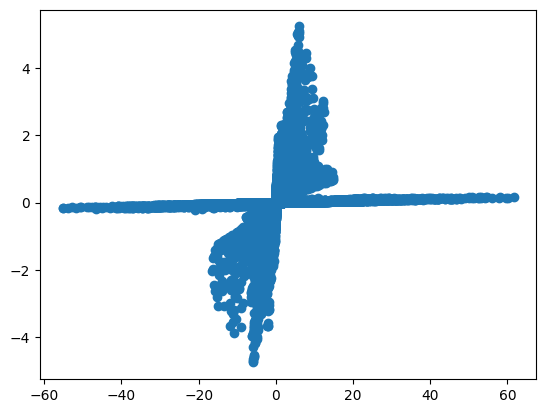

In [122]:
plt.scatter(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"]["perceptnet"][layer_name]["__call__"][0].ravel())
plt.show()

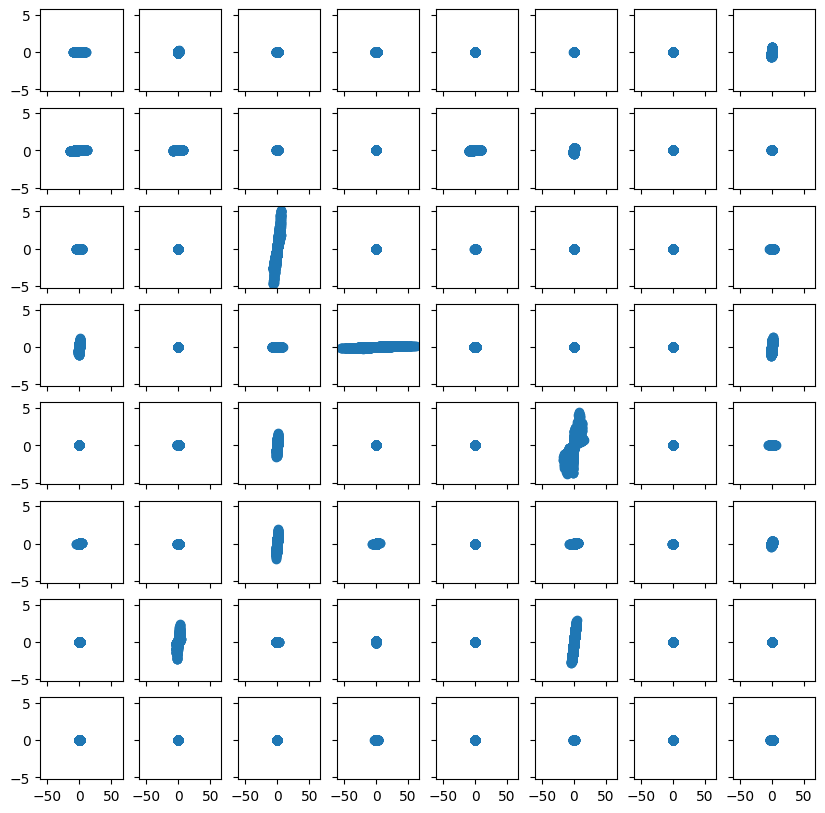

In [123]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"]["perceptnet"][prev_layer]["__call__"][0][0][0,:,:,i].ravel(),
               extras["intermediates"]["perceptnet"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

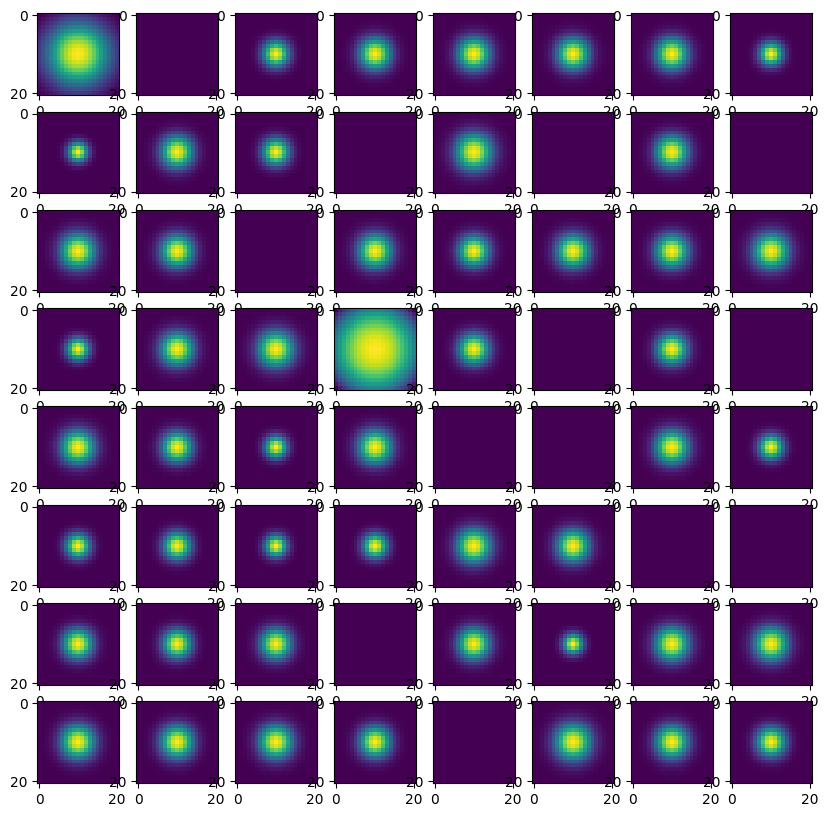

In [124]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["perceptnet"]["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
plt.show()

In [125]:
state.params["perceptnet"][prev_layer]["freq"]

array([-5.44568524e-03,  9.63117123e+00,  1.47960615e+01,  1.42831573e+01,
        8.06281662e+00,  1.69881077e+01,  8.65824509e+00,  1.33930082e+01,
        1.38713038e+00,  8.81481266e+00,  1.72590084e+01,  1.57369909e+01,
        5.53288078e+00,  1.53271923e+01,  1.04554453e+01,  1.63975735e+01,
        4.17904186e+00,  9.13327312e+00,  3.08148623e+00,  5.33376217e+00,
        1.14635401e+01,  4.28197050e+00,  7.13598871e+00,  1.40812998e+01,
        1.33571615e+01,  6.50697470e+00,  5.53669977e+00,  6.08701706e-02,
        9.52068043e+00,  1.47603102e+01,  1.44806805e+01,  1.68420086e+01,
        4.82947636e+00,  1.35535889e+01,  1.31901550e+01,  5.23423338e+00,
        5.04371929e+00,  1.90747082e+00,  5.16398048e+00,  1.05492468e+01,
        1.05483713e+01,  1.72462025e+01,  1.44157476e+01,  1.05490990e+01,
        5.23453808e+00,  8.81131744e+00,  1.27154055e+01,  9.51922131e+00,
        1.39385395e+01,  9.00700665e+00,  9.54949570e+00,  1.62193432e+01,
        9.47598457e+00,  

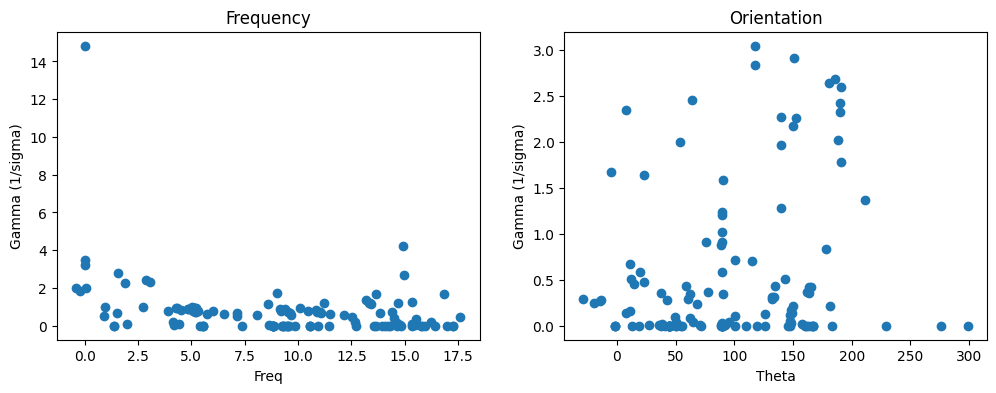

In [126]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(state.params["perceptnet"][prev_layer]["freq"], state.params["perceptnet"][layer_name]["FreqOrientGaussianGamma_0"]["gamma_f"])
axes[0].set_xlabel("Freq")
axes[0].set_ylabel("Gamma (1/sigma)")
axes[0].set_title("Frequency")

axes[1].scatter(state.params["perceptnet"][prev_layer]["theta"]*180/jnp.pi, state.params["perceptnet"][layer_name]["FreqOrientGaussianGamma_0"]["gamma_theta"])
axes[1].set_xlabel("Theta")
axes[1].set_ylabel("Gamma (1/sigma)")
axes[1].set_title("Orientation")

plt.show()

### Final output

In [135]:
state.params["coefs"]

array([ 1.5938097 , -0.39338708,  3.662039  ,  0.16157821], dtype=float32)

In [133]:
# fig, axes = plt.subplots(8,8, figsize=(40,40))
# for i, ax in enumerate(axes.ravel()):
#     ax.imshow(outputs[0,:,:,i])
#     ax.axis("off")
# plt.show()